In [65]:
import os
from math import sqrt
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb

pd.set_option('display.max_rows', 500)


# LSTM libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L

from src.models.predict_model import PredictModel

In [2]:
# train_data = pd.read_csv("../data/processed/train_preprocessed.csv")
# test_data = pd.read_csv("../data/processed/test_preprocessed.csv")
# validation_data = pd.read_csv("../data/processed/validate_preprocessed.csv")

In [3]:
# train_data.head(6)

In [4]:
def prepare_time_series_data(df: pd.DataFrame, n: int, target_column: str) -> pd.DataFrame:
    """
    Prepares time series data using the last n timestamps and the current timestamp
    to predict the target column.

    Args:
    - df (pd.DataFrame): The input data containing timestamps and feature columns.
    - n (int): The number of previous timestamps to use as features.
    - target_column (str): The name of the target column.

    Returns:
    - pd.DataFrame: A DataFrame where each row contains n+1 timestamps of features and the target value.
    """
    feature_columns = [col for col in df.columns if col != target_column and col != 'time']
    data = []
    columns = []

    # Generate column names for the reorganized DataFrame
    for i in range(n, 0, -1):
        columns += [f"{col}_t-{i}" for col in feature_columns]
    columns += [f"{col}_t" for col in feature_columns]  # Add current timestep features
    columns += [target_column]

    # Populate the rows with shifted data
    for i in tqdm(range(n, len(df)),
            desc="Preparing time series data",
            total=len(df),
            unit=" rows"
            ):
        row_features = df.iloc[i-n:i][feature_columns].values.flatten()  # Last n timesteps
        current_features = df.iloc[i][feature_columns].values  # Current timestep
        row_target = df.iloc[i][target_column]  # Target value
        data.append(list(row_features) + list(current_features) + [row_target])
    
    return pd.DataFrame(data, columns=columns)

In [2]:
# prepared_train_data = prepare_time_series_data(train_data, 6, 'target')
prepared_train_data = pd.read_csv("../data/processed/series_train_preprocessed.csv")

In [3]:
# prepared_test_data = prepare_time_series_data(test_data, 6, 'target')
prepared_test_data = pd.read_csv("../data/processed/series_test_preprocessed.csv")

In [4]:
# prepared_validation_data = prepare_time_series_data(validation_data, 6, 'target')
prepared_validation_data = pd.read_csv("../data/processed/series_validate_preprocessed.csv")

In [5]:
# prepared_train_data.to_csv("../data/processed/series_train_preprocessed.csv", index=False)
# prepared_test_data.to_csv("../data/processed/series_test_preprocessed.csv", index=False)
# prepared_validation_data.to_csv("../data/processed/series_validate_preprocessed.csv", index=False)

In [6]:
X_train = prepared_train_data.drop('target', axis=1)
y_train = prepared_train_data['target']

X_test = prepared_test_data.drop('target', axis=1)
y_test = prepared_test_data['target']

X_val = prepared_validation_data.drop('target', axis=1)
y_val = prepared_validation_data['target']

#### Base models for Feature importance


##### Random Forest Regressor

In [10]:
# Train a Random Forest Regressor
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,         # Number of trees in the forest
    max_depth=15,             # Maximum depth of each tree
    min_samples_split=10,     # Minimum samples required to split an internal node
    min_samples_leaf=4,       # Minimum samples required to be at a leaf node
    max_features='sqrt',      # Number of features to consider for best split
    bootstrap=True,           # Whether to use bootstrap samples
    n_jobs=-1,                # Use all available CPU cores
    random_state=42           # For reproducibility
)


In [11]:
# train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_jobs=-1, random_state=42)

In [12]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [13]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse}")

Random Forest MSE: 2.7640253188744983e-06


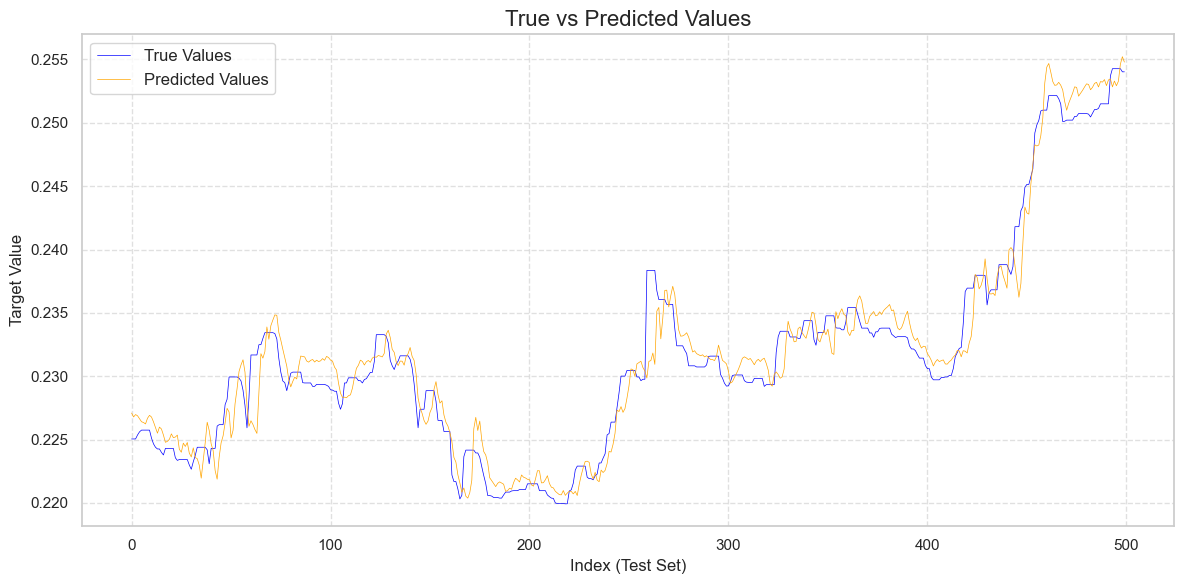

In [14]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

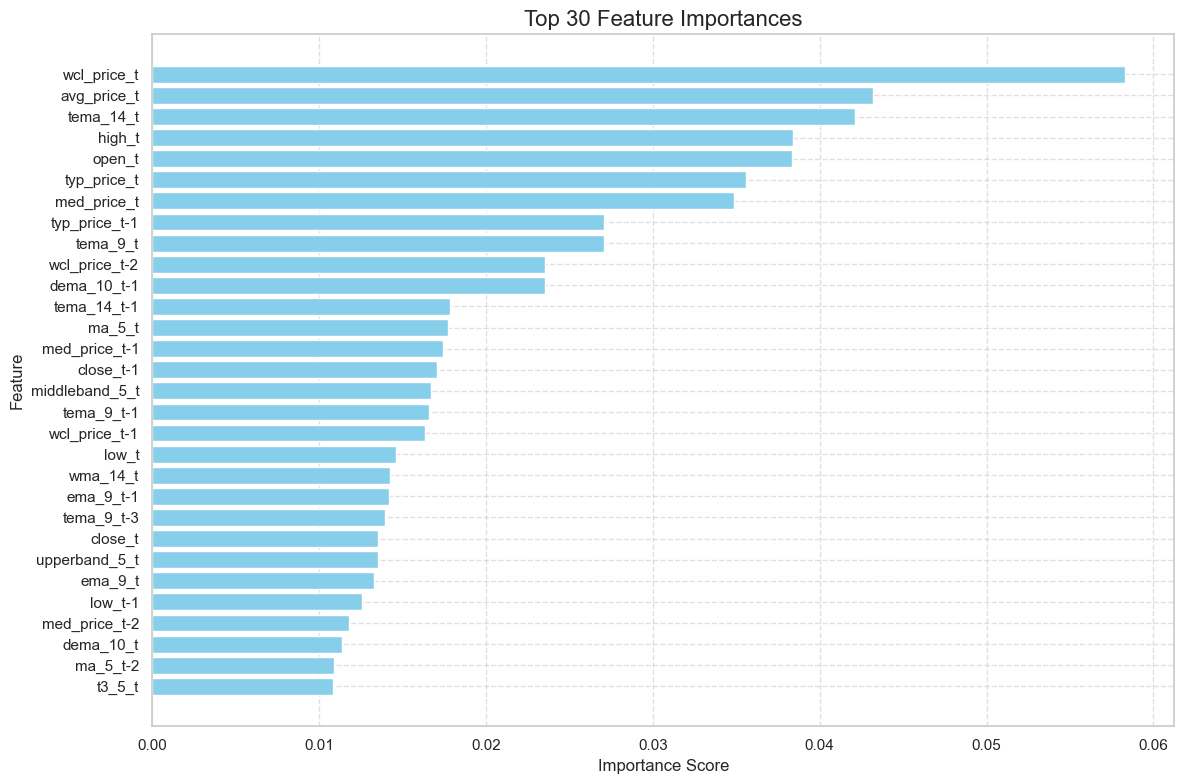

In [15]:
# plot the feature importances
# Get feature importances and their corresponding feature names
rf_feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = np.argsort(rf_feature_importances)[::-1]
rf_sorted_importances = rf_feature_importances[sorted_idx]
rf_sorted_features = feature_names[sorted_idx]

# Plot the feature importances
top_n = 30
plt.figure(figsize=(12, 8))
plt.barh(rf_sorted_features[:top_n][::-1], rf_sorted_importances[:top_n][::-1], color='skyblue')  # Top 20 features
plt.title(f'Top {top_n} Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
idx = 0
for i, j in zip(rf_sorted_features, rf_sorted_importances):
    idx += 1
    if "sentiment" in i:
        print(i, idx, j)

sentiment_score_t-5 481 1.1991802169263263e-07
sentiment_score_t-1 543 1.027066718954716e-07
sentiment_score_t-3 560 9.757561830793035e-08
sentiment_score_t-4 564 9.676289946753713e-08
sentiment_score_t 589 9.040236482640942e-08
sentiment_score_t-6 599 8.90079920376474e-08
sentiment_score_t-2 609 8.835104779413354e-08


In [17]:
rf_sorted_features[30]

'avg_price_t-1'

##### XGBoost Regressor

In [18]:
# Train a XGBoost Regressor
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,           # Number of trees
    learning_rate=0.1,          # Step size for weight updates
    max_depth=6,                # Depth of each tree
    min_child_weight=10,        # Minimum sum of weights in child nodes
    subsample=0.8,              # Subsample ratio for training data
    colsample_bytree=0.8,       # Subsample ratio for features
    gamma=0,                    # Minimum loss reduction for further partitioning
    reg_alpha=0.1,              # L1 regularization (prevents overfitting)
    reg_lambda=1.0,             # L2 regularization (prevents overfitting)
    random_state=42,            # Ensures reproducibility
    tree_method='hist',         # Faster tree construction for large datasets
    n_jobs=-1,                  # Use all available CPU threads
    early_stopping_rounds=10
)

In [19]:
# Train the model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)


[0]	validation_0-rmse:0.16944
[10]	validation_0-rmse:0.05926
[20]	validation_0-rmse:0.02088
[30]	validation_0-rmse:0.00782
[40]	validation_0-rmse:0.00386
[50]	validation_0-rmse:0.00302
[60]	validation_0-rmse:0.00289
[70]	validation_0-rmse:0.00287
[80]	validation_0-rmse:0.00286
[90]	validation_0-rmse:0.00286
[100]	validation_0-rmse:0.00285
[110]	validation_0-rmse:0.00285
[120]	validation_0-rmse:0.00285
[130]	validation_0-rmse:0.00285


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [110]:
# Make predictions
y_pred = xgb_model.predict(X_test)

In [112]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"XGBoost MSE: {mse}")

XGBoost MSE: 2.4673402378740997e-06


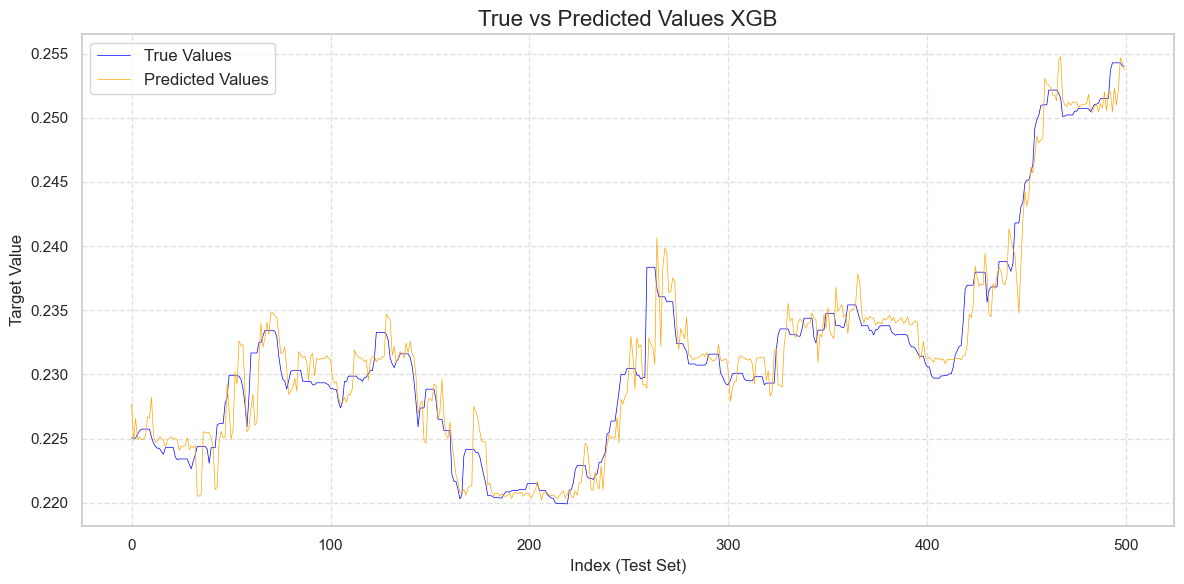

In [22]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values XGB', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

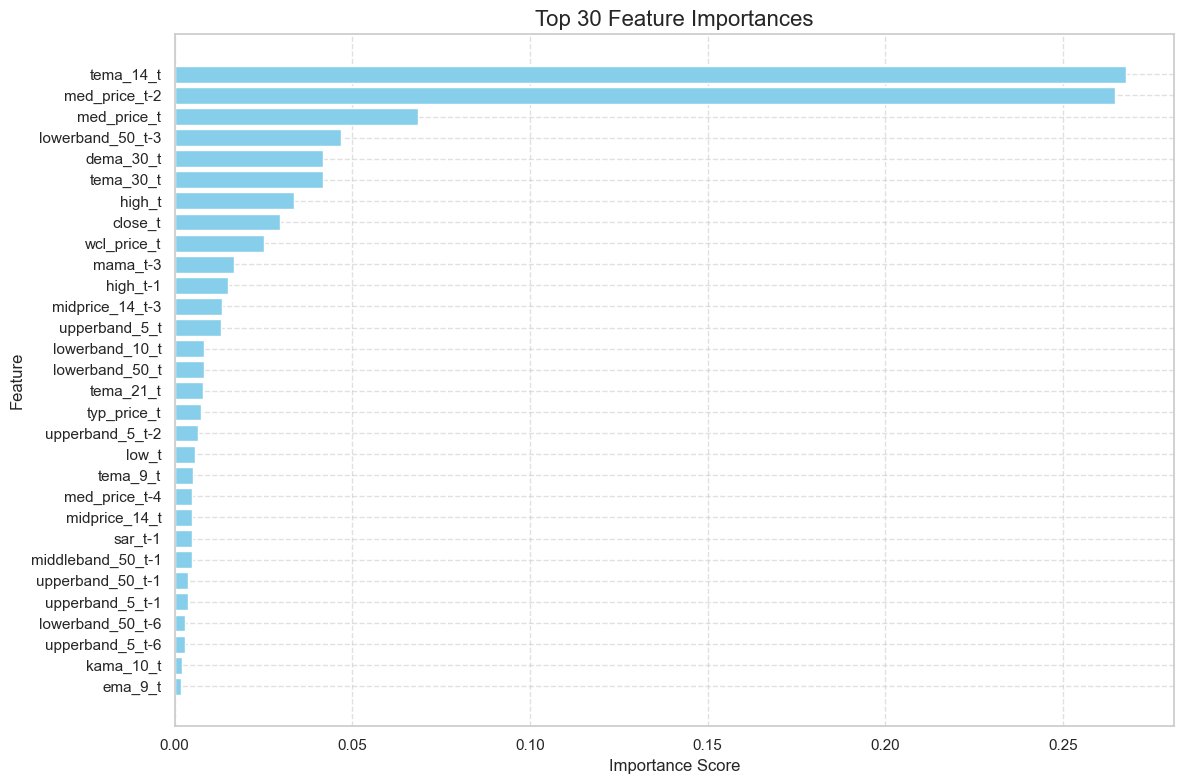

In [23]:
# plot the feature importances
# Get feature importances and their corresponding feature names
xgb_feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = np.argsort(xgb_feature_importances)[::-1]
xgb_sorted_importances = xgb_feature_importances[sorted_idx]
xgb_sorted_features = feature_names[sorted_idx]

# Plot the feature importances
top_n = 30
plt.figure(figsize=(12, 8))
plt.barh(xgb_sorted_features[:top_n][::-1], xgb_sorted_importances[:top_n][::-1], color='skyblue')  # Top 20 features
plt.title(f'Top {top_n} Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
idx = 0
for i, j in zip(xgb_sorted_features, xgb_sorted_importances):
    idx += 1
    if "sentiment" in i:
        print(i, idx, j)

sentiment_score_t 193 5.9050876e-07
sentiment_score_t-6 217 4.3983712e-07
sentiment_score_t-1 252 3.4315335e-07
sentiment_score_t-5 285 2.5283745e-07
sentiment_score_t-4 287 2.506846e-07
sentiment_score_t-3 288 2.4789972e-07
sentiment_score_t-2 307 2.2035714e-07


##### LightGBM Regressor

In [25]:
# Train a Light GBM 
# Define initial LightGBM parameters
params = {
    "boosting_type": "gbdt",           # Gradient Boosting Decision Tree
    "objective": "regression",         # Regression task
    "metric": "rmse",                  # Root Mean Squared Error for evaluation
    "num_leaves": 31,                  # Maximum number of leaves in one tree
    "learning_rate": 0.05,             # Lower learning rate with more boosting rounds
    "feature_fraction": 0.8,           # Percentage of features used per tree
    "bagging_fraction": 0.8,           # Percentage of data used per tree
    "bagging_freq": 5,                 # Perform bagging every 5 iterations
    "max_depth": -1,                   # No maximum depth restriction
    "lambda_l1": 0.1,                  # L1 regularization
    "lambda_l2": 0.2,                  # L2 regularization
    "verbosity": -1,                   # Suppress output
    "n_jobs": -1,                      # Use all CPU cores
    "seed": 42,                        # Seed for reproducibility
    "early_stopping_rounds": 10,       # Stop if no improvement in 10 rounds
    "verbose_eval": 10                 # Print evaluation results every 10 rounds
}

In [26]:
# Convert training data into LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [27]:
# Train the model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,              # Maximum boosting iterations
    valid_sets=[train_data, valid_data],
)

In [28]:
# Make predictions
y_pred = lgb_model.predict(X_test)

In [29]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"LightGBM MSE: {mse}")

LightGBM MSE: 2.667824664104948e-06


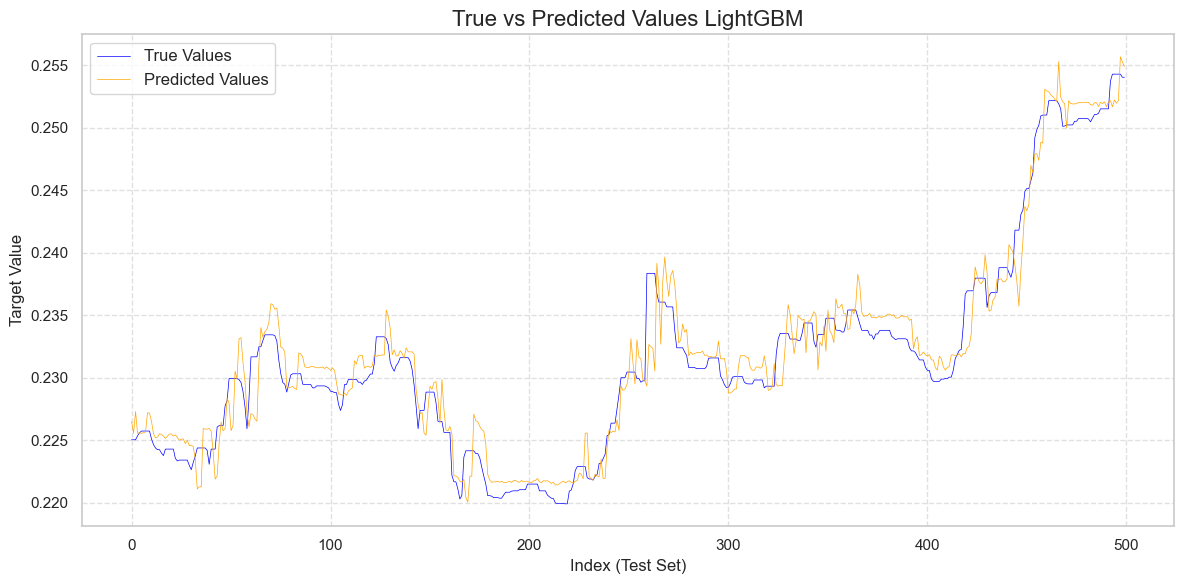

In [30]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values LightGBM', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

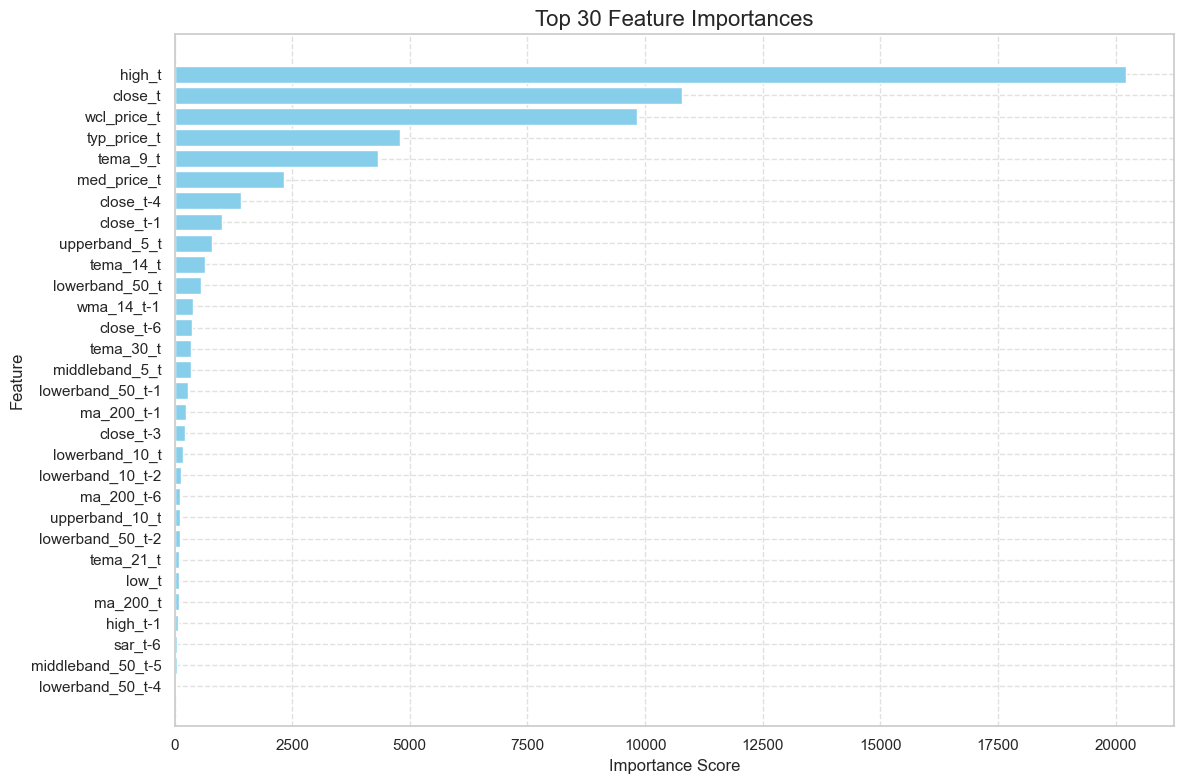

In [31]:
# plot the feature importances
# Get feature importances and their corresponding feature names
lgb_feature_importances = lgb_model.feature_importance(importance_type="gain")  # Use "split" for split count
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = np.argsort(lgb_feature_importances)[::-1]
lgb_sorted_importances = lgb_feature_importances[sorted_idx]
lgb_sorted_features = feature_names[sorted_idx]

# Plot the feature importances
top_n = 30
plt.figure(figsize=(12, 8))
plt.barh(lgb_sorted_features[:top_n][::-1], lgb_sorted_importances[:top_n][::-1], color='skyblue')  # Top 20 features
plt.title(f'Top {top_n} Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


In [32]:
idx = 0
for i, j in zip(lgb_sorted_features, lgb_sorted_importances):
    idx += 1
    if "sentiment" in i:
        print(i, idx, j)

sentiment_score_t-6 186 0.010209967906121165
sentiment_score_t-5 187 0.009853550232946873
sentiment_score_t 224 0.003646032011602074
sentiment_score_t-2 253 0.00212594005279243
sentiment_score_t-4 261 0.0017704290221445262
sentiment_score_t-1 299 0.0008775509777478874
sentiment_score_t-3 879 0.0


#### Top Features

In [33]:
# get set of top 30 features common to all models
all_30 = []
for list in rf_sorted_features[:30], xgb_sorted_features[:30], lgb_sorted_features[:30]:
    all_30.extend(list)
top_features_30 = set(all_30)

# get set of top 20 features common to all models
all_20 = []
for list in rf_sorted_features[:20], xgb_sorted_features[:20], lgb_sorted_features[:20]:
    all_20.extend(list)
top_features_20 = set(all_20)

In [34]:
top_features_30

{'avg_price_t',
 'close_t',
 'close_t-1',
 'close_t-3',
 'close_t-4',
 'close_t-6',
 'dema_10_t',
 'dema_10_t-1',
 'dema_30_t',
 'ema_9_t',
 'ema_9_t-1',
 'high_t',
 'high_t-1',
 'kama_10_t',
 'low_t',
 'low_t-1',
 'lowerband_10_t',
 'lowerband_10_t-2',
 'lowerband_50_t',
 'lowerband_50_t-1',
 'lowerband_50_t-2',
 'lowerband_50_t-3',
 'lowerband_50_t-4',
 'lowerband_50_t-6',
 'ma_200_t',
 'ma_200_t-1',
 'ma_200_t-6',
 'ma_5_t',
 'ma_5_t-2',
 'mama_t-3',
 'med_price_t',
 'med_price_t-1',
 'med_price_t-2',
 'med_price_t-4',
 'middleband_50_t-1',
 'middleband_50_t-5',
 'middleband_5_t',
 'midprice_14_t',
 'midprice_14_t-3',
 'open_t',
 'sar_t-1',
 'sar_t-6',
 't3_5_t',
 'tema_14_t',
 'tema_14_t-1',
 'tema_21_t',
 'tema_30_t',
 'tema_9_t',
 'tema_9_t-1',
 'tema_9_t-3',
 'typ_price_t',
 'typ_price_t-1',
 'upperband_10_t',
 'upperband_50_t-1',
 'upperband_5_t',
 'upperband_5_t-1',
 'upperband_5_t-2',
 'upperband_5_t-6',
 'wcl_price_t',
 'wcl_price_t-1',
 'wcl_price_t-2',
 'wma_14_t',
 'wma_1

In [35]:
top_features_20

{'avg_price_t',
 'close_t',
 'close_t-1',
 'close_t-3',
 'close_t-4',
 'close_t-6',
 'dema_10_t-1',
 'dema_30_t',
 'high_t',
 'high_t-1',
 'low_t',
 'lowerband_10_t',
 'lowerband_10_t-2',
 'lowerband_50_t',
 'lowerband_50_t-1',
 'lowerband_50_t-3',
 'ma_200_t-1',
 'ma_5_t',
 'mama_t-3',
 'med_price_t',
 'med_price_t-1',
 'med_price_t-2',
 'middleband_5_t',
 'midprice_14_t-3',
 'open_t',
 'tema_14_t',
 'tema_14_t-1',
 'tema_21_t',
 'tema_30_t',
 'tema_9_t',
 'tema_9_t-1',
 'typ_price_t',
 'typ_price_t-1',
 'upperband_5_t',
 'upperband_5_t-2',
 'wcl_price_t',
 'wcl_price_t-1',
 'wcl_price_t-2',
 'wma_14_t',
 'wma_14_t-1'}

In [36]:
news_features = [col for col in X_train.columns if "sentiment" in col or "impact" in col]

In [37]:
len(news_features)

14

In [38]:
top_features_20_news = top_features_20.union(news_features)
top_features_30_news = top_features_30.union(news_features)

In [163]:
len(top_features_30_news)

77

In [40]:
rf_top_features = rf_sorted_features[:30].array.tolist()
rf_top_features.extend(news_features)
xgb_top_features = xgb_sorted_features[:30].array.tolist()
xgb_top_features.extend(news_features)
lgb_top_features = lgb_sorted_features[:30].array.tolist()
lgb_top_features.extend(news_features)

# Prepare the data with the top features
X_train_rf_top = X_train[rf_top_features]
X_test_rf_top = X_test[rf_top_features]
X_val_rf_top = X_val[rf_top_features]

X_train_xgb_top = X_train[xgb_top_features]
X_test_xgb_top = X_test[xgb_top_features]
X_val_xgb_top = X_val[xgb_top_features]

X_train_lgb_top = X_train[lgb_top_features]
X_test_lgb_top = X_test[lgb_top_features]
X_val_lgb_top = X_val[lgb_top_features]

In [41]:
y_train.shape

(218543,)

#### LSTM RF Features Regressor

In [42]:
# ## RF features based LSTM  model
timesteps = 1
features = 30 + len(news_features)
# lr = 0.0001  # Learning rate
# # Define the model
# rf_top_model = Sequential()
# rf_top_model.add(L.Bidirectional(L.LSTM(timesteps, activation='tanh', input_shape=(timesteps, features), return_sequences=True)))
# rf_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
# rf_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
# rf_top_model.add(L.LSTM(64, activation='tanh', return_sequences=False))
# rf_top_model.add(L.BatchNormalization())
# rf_top_model.add(L.RepeatVector(timesteps))
# rf_top_model.add(L.LSTM(timesteps, activation='tanh', return_sequences=True))
# rf_top_model.add(L.BatchNormalization())
# rf_top_model.add(L.LSTM(64, activation='tanh', return_sequences=True))
# rf_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
# rf_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
# rf_top_model.add(L.Bidirectional(L.LSTM(128, activation='tanh', return_sequences=False)))
# rf_top_model.add(L.Dropout(0.2))
# rf_top_model.add(L.Dense(1))
# # Compile the model
# adam = tf.keras.optimizers.Adam(lr)
# rf_top_model.compile(optimizer=adam, loss='mse', metrics=['mse'])  # Mean squared error for regression, mean absolute error
# rf_top_model.build(input_shape=(None, timesteps, features))
# # Summary of the model
# rf_top_model.summary()

In [43]:
X_train_rf_top = X_train_rf_top.values.reshape(-1, timesteps, features)
X_test_rf_top = X_test_rf_top.values.reshape(-1, timesteps, features)
X_val_rf_top = X_val_rf_top.values.reshape(-1, timesteps, features)

In [44]:
len(X_train_rf_top)
# len(y_train)

218543

In [45]:
# # set conditions to stop training if the model begins 
# epochs = 100 
# patience = int(sqrt(epochs))
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                 patience=patience, 
#                                                 mode='min',
#                                                 restore_best_weights=True)

# rf_top_model.fit(
#     X_train_rf_top,
#     y_train,
#     epochs=epochs,
#     batch_size=128,
#     validation_data=(
#         X_val_rf_top,
#         y_val
#     ),
#     callbacks=[early_stopping]
# )


In [46]:
# rf_top_model.save("../models/rf_top_model.h5")

In [47]:
rf_top_model = tf.keras.models.load_model("../models/rf_top_model.h5")

In [48]:
# Make predictions
y_pred = rf_top_model.predict(X_test_rf_top)

843/843 [==============================] - 10s 5ms/step


In [49]:
# Calculate the root mean squared error
rmse_rf_top_model = root_mean_squared_error(y_test, y_pred)
print(f"RF Top Features LSTM RMSE: {mse}")

RF Top Features LSTM RMSE: 2.667824664104948e-06


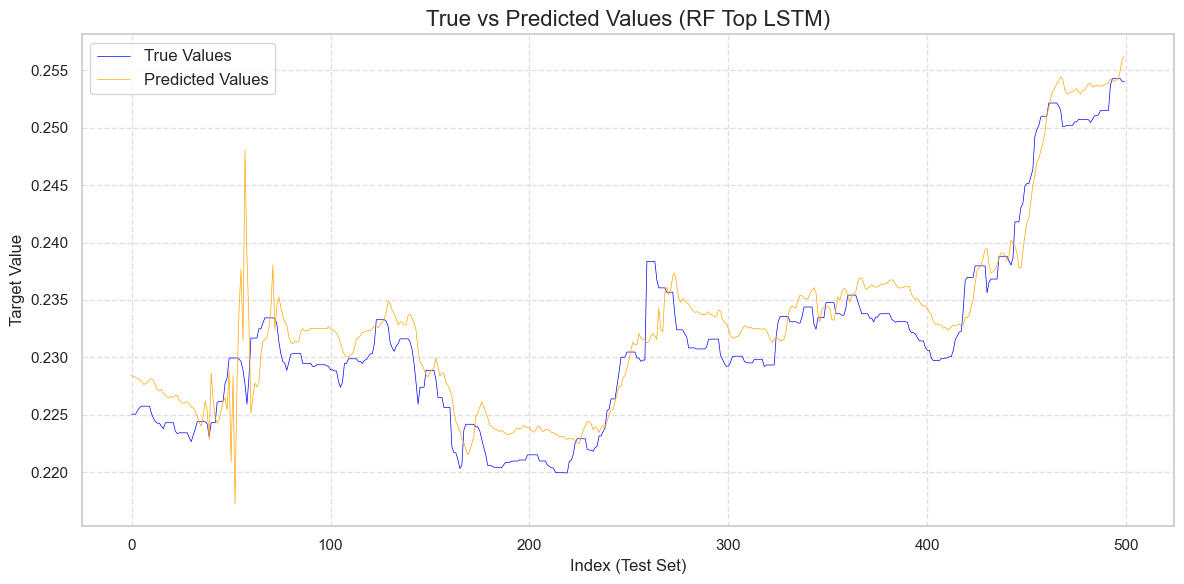

In [50]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values (RF Top LSTM)', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

#### LSTM XGB Features Regressor

In [51]:
# ## XGB features based LSTM  model
# timesteps = 1
# features = 30 + len(news_features)
# lr = 0.0001  # Learning rate
# # Define the model
# xgb_top_model = Sequential()
# xgb_top_model.add(L.Bidirectional(L.LSTM(timesteps, activation='tanh', input_shape=(timesteps, features), return_sequences=True)))
# xgb_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
# xgb_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
# xgb_top_model.add(L.LSTM(64, activation='tanh', return_sequences=False))
# xgb_top_model.add(L.BatchNormalization())
# xgb_top_model.add(L.RepeatVector(timesteps))
# xgb_top_model.add(L.LSTM(timesteps, activation='tanh', return_sequences=True))
# xgb_top_model.add(L.BatchNormalization())
# xgb_top_model.add(L.LSTM(64, activation='tanh', return_sequences=True))
# xgb_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
# xgb_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
# xgb_top_model.add(L.Bidirectional(L.LSTM(128, activation='tanh', return_sequences=False)))
# xgb_top_model.add(L.Dropout(0.2))
# xgb_top_model.add(L.Dense(1))
# # Compile the model
# adam = tf.keras.optimizers.Adam(lr)
# xgb_top_model.compile(optimizer=adam, loss='mse', metrics=['mse'])  # Mean squared error for regression, mean absolute error
# xgb_top_model.build(input_shape=(None, timesteps, features))
# # Summary of the model
# xgb_top_model.summary()

In [52]:
X_train_xgb_top = X_train_xgb_top.values.reshape(-1, timesteps, features)
X_test_xgb_top = X_test_xgb_top.values.reshape(-1, timesteps, features)
X_val_xgb_top = X_val_xgb_top.values.reshape(-1, timesteps, features)

In [53]:
# # set conditions to stop training if the model begins 
# epochs = 100 
# patience = int(sqrt(epochs))
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                 patience=patience, 
#                                                 mode='min',
#                                                 restore_best_weights=True)

# xgb_top_model.fit(
#     X_train_xgb_top,
#     y_train,
#     epochs=epochs,
#     batch_size=128,
#     validation_data=(
#         X_val_xgb_top,
#         y_val
#     ),
#     callbacks=[early_stopping]
# )

In [54]:
# Save the model
# xgb_top_model.save("../models/xgb_top_model.h5")

In [55]:
# Load the model
xgb_top_model = tf.keras.models.load_model("../models/xgb_top_model.h5")

In [56]:
# Make predictions
y_pred = xgb_top_model.predict(X_test_xgb_top)

843/843 [==============================] - 6s 5ms/step


In [57]:
# Calculate the root mean squared error
rmse_xgb_top_model = root_mean_squared_error(y_test, y_pred)
print(f"XGB Top Features LSTM RMSE: {mse}")

XGB Top Features LSTM RMSE: 2.667824664104948e-06


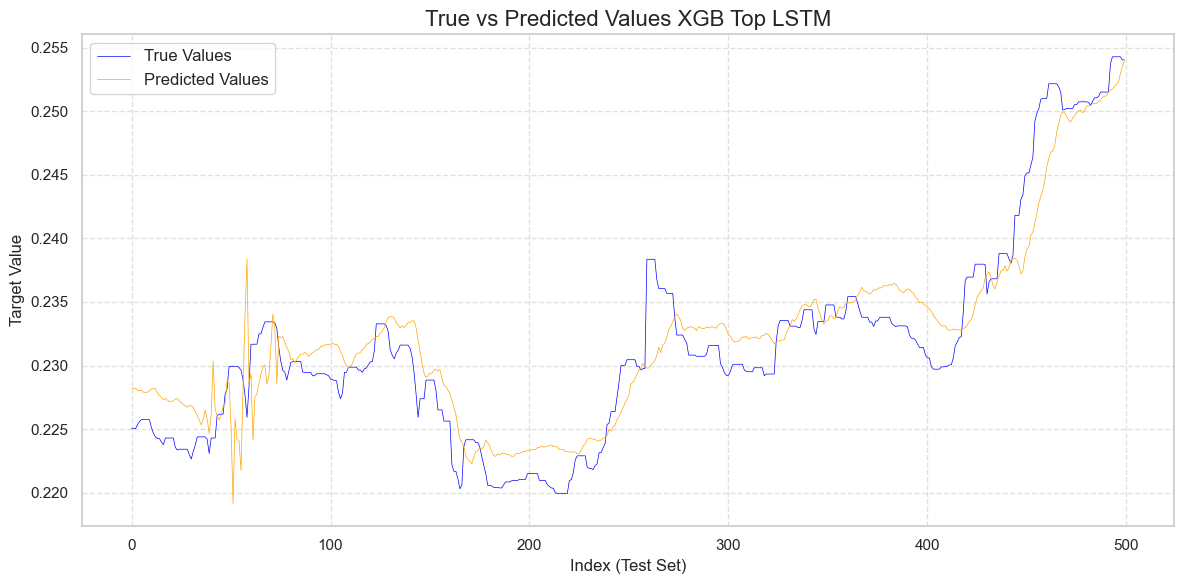

In [58]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values XGB Top LSTM', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

#### LightGBM LSTM Regressor

In [59]:
# ## LightGBM features based LSTM  model
# timesteps = 1
# features = 30 + len(news_features)
# lr = 0.0001  # Learning rate
# # Define the model
# lgb_top_model = Sequential()
# lgb_top_model.add(L.Bidirectional(L.LSTM(timesteps, activation='tanh', input_shape=(timesteps, features), return_sequences=True)))
# lgb_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
# lgb_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
# lgb_top_model.add(L.LSTM(64, activation='tanh', return_sequences=False))
# lgb_top_model.add(L.BatchNormalization())
# lgb_top_model.add(L.RepeatVector(timesteps))
# lgb_top_model.add(L.LSTM(timesteps, activation='tanh', return_sequences=True))
# lgb_top_model.add(L.BatchNormalization())
# lgb_top_model.add(L.LSTM(64, activation='tanh', return_sequences=True))
# lgb_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
# lgb_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
# lgb_top_model.add(L.Bidirectional(L.LSTM(128, activation='tanh', return_sequences=False)))
# lgb_top_model.add(L.Dropout(0.2))
# lgb_top_model.add(L.Dense(1))
# # Compile the model
# adam = tf.keras.optimizers.Adam(lr)
# lgb_top_model.compile(optimizer=adam, loss='mse', metrics=['mse'])  # Mean squared error for regression, mean absolute error
# lgb_top_model.build(input_shape=(None, timesteps, features))
# # Summary of the model
# lgb_top_model.summary()

In [60]:
X_train_lgb_top = X_train_lgb_top.values.reshape(-1, timesteps, features)
X_test_lgb_top = X_test_lgb_top.values.reshape(-1, timesteps, features)
X_val_lgb_top = X_val_lgb_top.values.reshape(-1, timesteps, features)

In [61]:
# # set conditions to stop training if the model begins 
# epochs = 100 
# patience = int(sqrt(epochs))
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                                 patience=patience, 
#                                                 mode='min',
#                                                 restore_best_weights=True)

# lgb_top_model.fit(
#     X_train_lgb_top,
#     y_train,
#     epochs=epochs,
#     batch_size=128,
#     validation_data=(
#         X_val_lgb_top,
#         y_val
#     ),
#     callbacks=[early_stopping]
# )

In [62]:
# Save the model
# lgb_top_model.save("../models/lgb_top_model.h5")

In [63]:
# Load the model
lgb_top_model = tf.keras.models.load_model("../models/lgb_top_model.h5")

In [64]:
# Make predictions
y_pred = lgb_top_model.predict(X_test_lgb_top)

843/843 [==============================] - 7s 5ms/step


In [82]:
# Calculate the root mean squared error
rmse_lgb_top_model = root_mean_squared_error(y_test, y_pred)
print(f"LightGBM Top Features LSTM RMSE: {mse}")

LightGBM Top Features LSTM RMSE: 0.002983869204176954


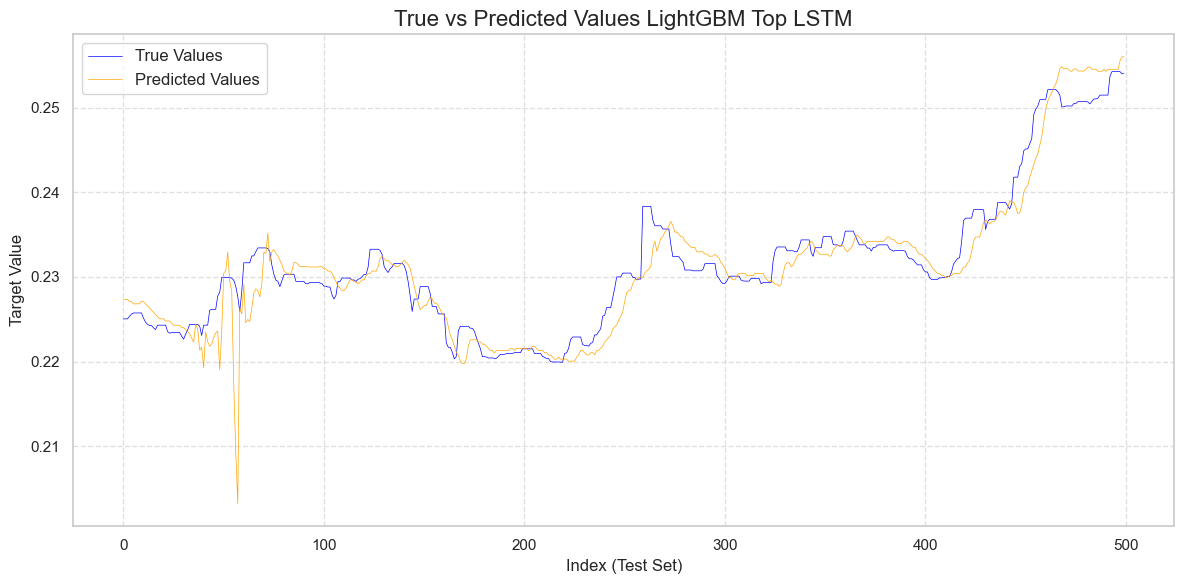

In [66]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values LightGBM Top LSTM', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

#### Final Feature Importance

In [71]:
# Calculate final feature importances
scaled_rf_importances = MinMaxScaler().fit_transform(rf_sorted_importances.reshape(-1, 1))
scaled_xgb_importances = MinMaxScaler().fit_transform(xgb_sorted_importances.reshape(-1, 1))
scaled_lgb_importances = MinMaxScaler().fit_transform(lgb_sorted_importances.reshape(-1, 1))


In [93]:
# sort all top features
scores_30_news = []
scores_20_news = []

for feature in top_features_30_news:
    feature_score = sum([
        (scaled_rf_importances[rf_sorted_features.to_list().index(feature)][0])/rmse_rf_top_model,
        (scaled_xgb_importances[xgb_sorted_features.to_list().index(feature)][0])/rmse_xgb_top_model,
        (scaled_lgb_importances[lgb_sorted_features.to_list().index(feature)][0])/rmse_lgb_top_model
    ])
    scores_30_news.append((feature, feature_score))

for feature in top_features_20_news:
    feature_score = sum([
        (scaled_rf_importances[rf_sorted_features.to_list().index(feature)][0])/rmse_rf_top_model,
        (scaled_xgb_importances[xgb_sorted_features.to_list().index(feature)][0])/rmse_xgb_top_model,
        (scaled_lgb_importances[lgb_sorted_features.to_list().index(feature)][0])/rmse_lgb_top_model
    ])
    scores_20_news.append((feature, feature_score))


In [97]:
sorted_scores_30_news = sorted(scores_30_news, key=lambda x: x[1], reverse=True)
sorted_scores_20_news = sorted(scores_20_news, key=lambda x: x[1], reverse=True)

top_30_features_across = [feature for feature, score in sorted_scores_30_news]
top_20_features_across = [feature for feature, score in sorted_scores_20_news]

top_30_features_final = top_30_features_across[:30]
top_20_features_final = top_20_features_across[:20]


In [117]:
# Save feature lists
joblib.dump(
    rf_sorted_features,
    "../artefacts/rf_sorted_features.pkl"
)

joblib.dump(
    xgb_sorted_features,
    "../artefacts/xgb_sorted_features.pkl"
)

joblib.dump(
    lgb_sorted_features,
    "../artefacts/lgb_sorted_features.pkl"
)

joblib.dump(
    top_30_features_across,
    "../artefacts/top_30_features_across.pkl"
)

joblib.dump(
    top_20_features_across,
    "../artefacts/top_20_features_across.pkl"
)

joblib.dump(
    top_30_features_final,
    "../artefacts/top_30_features_final.pkl"
)

joblib.dump(
    top_20_features_final,
    "../artefacts/top_20_features_final.pkl"
)

['../artefacts/top_20_features_final.pkl']

#### Prepare Data

In [7]:
# Load feature lists
rf_sorted_features = joblib.load("../artefacts/rf_sorted_features.pkl")
xgb_sorted_features = joblib.load("../artefacts/xgb_sorted_features.pkl")
lgb_sorted_features = joblib.load("../artefacts/lgb_sorted_features.pkl")

top_30_features_across = joblib.load("../artefacts/top_30_features_across.pkl")
top_20_features_across = joblib.load("../artefacts/top_20_features_across.pkl")

top_30_features_final = joblib.load("../artefacts/top_30_features_final.pkl")
top_20_features_final = joblib.load("../artefacts/top_20_features_final.pkl")

In [8]:
# Prepare the data with the top features
X_train_30_across = X_train[top_30_features_across]
X_test_30_across = X_test[top_30_features_across]
X_val_30_across = X_val[top_30_features_across]

X_train_20_across = X_train[top_20_features_across]
X_test_20_across = X_test[top_20_features_across]
X_val_20_across = X_val[top_20_features_across]

X_train_30_final = X_train[top_30_features_final]
X_test_30_final = X_test[top_30_features_final]
X_val_30_final = X_val[top_30_features_final]

X_train_20_final = X_train[top_20_features_final]
X_test_20_final = X_test[top_20_features_final]
X_val_20_final = X_val[top_20_features_final]

In [9]:
# reshape the data
def reshape_data(X_train, X_test, X_val):
    timesteps = 1
    X_train = X_train.values.reshape(-1, timesteps, len(X_train.columns))
    X_test = X_test.values.reshape(-1, timesteps, len(X_test.columns))
    X_val = X_val.values.reshape(-1, timesteps, len(X_val.columns))
    return X_train, X_test, X_val

X_train_exp, X_test_exp, X_val_exp = reshape_data(
    X_train_20_final,
    X_test_20_final,
    X_val_20_final)

X_train_20_final_gru, X_test_20_final_gru, X_val_20_final_gru = reshape_data(
    X_train_20_final,
    X_test_20_final,
    X_val_20_final)

#### Experiemntal Models

In [ ]:
# Experimental LSTM  model
timesteps = 1
features = X_train_exp.shape[2]
lr = 0.0001  # Learning rate
# Define the model
experimental_model = Sequential()
experimental_model.add(L.Bidirectional(L.LSTM(timesteps, activation='tanh', input_shape=(timesteps, features), return_sequences=True)))
experimental_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
experimental_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
experimental_model.add(L.LSTM(64, activation='tanh', return_sequences=False))
experimental_model.add(L.BatchNormalization())
experimental_model.add(L.RepeatVector(timesteps))
experimental_model.add(L.LSTM(timesteps, activation='tanh', return_sequences=True))
experimental_model.add(L.BatchNormalization())
experimental_model.add(L.LSTM(64, activation='tanh', return_sequences=True))
experimental_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
experimental_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
experimental_model.add(L.Bidirectional(L.LSTM(128, activation='tanh', return_sequences=False)))
experimental_model.add(L.Dropout(0.2))
experimental_model.add(L.Dense(1))
# Compile the model
adam = tf.keras.optimizers.Adam(lr)
experimental_model.compile(optimizer=adam, loss='mse', metrics=['mse'])  # Mean squared error for regression, mean absolute error
experimental_model.build(input_shape=(None, timesteps, features))
# Summary of the model
experimental_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 2)             176       
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            265216    
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0

In [20]:
# Define the model
gru_model = Sequential()

gru_model.add(L.GRU(units=256, return_sequences=True, input_shape=(timesteps, features), recurrent_dropout=0.2))
gru_model.add(L.Dropout(0.2))
gru_model.add(L.GRU(units=128, return_sequences=True, recurrent_dropout=0.2))
gru_model.add(L.Dropout(0.2))
gru_model.add(L.GRU(units=64, return_sequences=False))
gru_model.add(L.Dense(1, activation='linear'))

# Compile the model
adam = tf.keras.optimizers.Adam(lr)
gru_model.compile(optimizer=adam, loss='mse', metrics=['mse'])  # Mean squared error for regression, mean absolute error
gru_model.build(input_shape=(None, timesteps, features))
# Summary of the model
gru_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 1, 256)            213504    
                                                                 
 dropout_3 (Dropout)         (None, 1, 256)            0         
                                                                 
 gru_5 (GRU)                 (None, 1, 128)            148224    
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 gru_6 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 399,041
Trainable params: 399,041
Non-tr

In [21]:
# set conditions to stop training if the model begins 
epochs = 100 
patience = int(sqrt(epochs))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=patience, 
                                                mode='min',
                                                restore_best_weights=True)

gru_model.fit(
    X_train_exp,
    y_train,
    epochs=epochs,
    batch_size=128,
    validation_data=(
        X_val_exp,
        y_val
    ),
    callbacks=[early_stopping]
)

Epoch 1/100
1708/1708 [==============================] - 23s 12ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 7.5307e-06 - val_mse: 7.5307e-06
Epoch 2/100
1708/1708 [==============================] - 19s 11ms/step - loss: 5.1377e-04 - mse: 5.1377e-04 - val_loss: 7.9645e-06 - val_mse: 7.9645e-06
Epoch 3/100
1708/1708 [==============================] - 19s 11ms/step - loss: 3.1728e-04 - mse: 3.1728e-04 - val_loss: 1.2366e-05 - val_mse: 1.2366e-05
Epoch 4/100
1708/1708 [==============================] - 19s 11ms/step - loss: 1.8280e-04 - mse: 1.8280e-04 - val_loss: 1.6379e-05 - val_mse: 1.6379e-05
Epoch 5/100
1708/1708 [==============================] - 20s 11ms/step - loss: 1.1973e-04 - mse: 1.1973e-04 - val_loss: 2.9509e-05 - val_mse: 2.9509e-05
Epoch 6/100
1708/1708 [==============================] - 19s 11ms/step - loss: 1.0509e-04 - mse: 1.0509e-04 - val_loss: 1.2597e-05 - val_mse: 1.2597e-05
Epoch 7/100
1708/1708 [==============================] - 19s 11ms/step - loss: 1.0078e-04 

In [25]:
# Save the model
gru_model.save("../models/gru_model.h5")

In [22]:
# Make predictions
y_pred = gru_model.predict(X_test_exp)

843/843 [==============================] - 2s 2ms/step


In [23]:
# Calculate the root mean squared error
rmse_experimental_model = root_mean_squared_error(y_test, y_pred)
print(f"Experimental GRU RMSE: {rmse_experimental_model}")

Experimental LSTM RMSE: 0.0021553384187651455


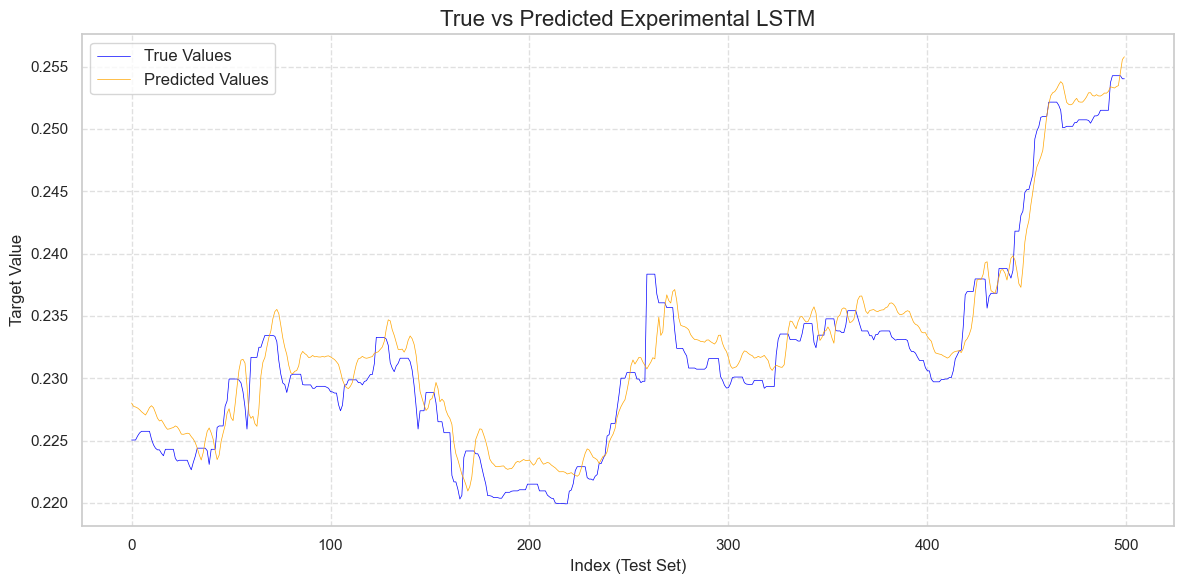

In [24]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Experimental LSTM', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
# Train Final XGBoost Regressor
# Initialize the XGBoost model
xgb_model_top_20 = XGBRegressor(
    n_estimators=60,           # Number of trees
    learning_rate=0.1,          # Step size for weight updates
    max_depth=20,                # Depth of each tree
    min_child_weight=10,        # Minimum sum of weights in child nodes
    subsample=0.8,              # Subsample ratio for training data
    colsample_bytree=0.8,       # Subsample ratio for features
    gamma=0,                    # Minimum loss reduction for further partitioning
    reg_alpha=0.1,              # L1 regularization (prevents overfitting)
    reg_lambda=1.0,             # L2 regularization (prevents overfitting)
    random_state=42,            # Ensures reproducibility
    tree_method='hist',         # Faster tree construction for large datasets
    n_jobs=-1,                  # Use all available CPU threads
    # early_stopping_rounds=10
)

In [33]:
# Train the model
xgb_model_top_20.fit(X_train[top_20_features_final], y_train, eval_set=[(X_val[top_20_features_final], y_val)], verbose=10)

[0]	validation_0-rmse:0.16941
[10]	validation_0-rmse:0.05922
[20]	validation_0-rmse:0.02084
[30]	validation_0-rmse:0.00786
[40]	validation_0-rmse:0.00405
[50]	validation_0-rmse:0.00331
[59]	validation_0-rmse:0.00322


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Save the model
# xgb_model_top_20.save_model("../models/xgb_model_top_20.ubj")

In [40]:
# Load the model
# xgb_model_top_20 = XGBRegressor()
# xgb_model_top_20.load_model("../models/xgb_model_top_20.ubj")

In [41]:
# Make predictions
y_pred = xgb_model_top_20.predict(X_test[top_20_features_final])

In [42]:
# Calculate the mean squared error
rmse = root_mean_squared_error(y_test, y_pred)
print(f"XGBoost RMSE: {rmse}")

XGBoost RMSE: 0.0018131734400056692


In [62]:
# Train Final LightGBM Regressor
# Define initial LightGBM parameters
params = {
    "boosting_type": "gbdt",           # Gradient Boosting Decision Tree
    "objective": "regression",         # Regression task
    "metric": "rmse",                  # Root Mean Squared Error for evaluation
    "num_leaves": 31,                  # Maximum number of leaves in one tree
    "learning_rate": 0.05,             # Lower learning rate with more boosting rounds
    "feature_fraction": 0.8,           # Percentage of features used per tree
    "bagging_fraction": 0.8,           # Percentage of data used per tree
    "bagging_freq": 5,                 # Perform bagging every 5 iterations
    "max_depth": -1,                   # No maximum depth restriction
    "lambda_l1": 0.1,                  # L1 regularization
    "lambda_l2": 0.2,                  # L2 regularization
    "verbosity": -1,                   # Suppress output
    "n_jobs": -1,                      # Use all CPU cores
    "seed": 42,                        # Seed for reproducibility
    "early_stopping_rounds": 10,       # Stop if no improvement in 10 rounds
    "verbose_eval": 10                 # Print evaluation results every 10 rounds
}

In [63]:
# Convert training data into LightGBM dataset
train_data = lgb.Dataset(X_train[top_20_features_final], label=y_train)
valid_data = lgb.Dataset(X_val[top_20_features_final], label=y_val, reference=train_data)

In [64]:
# Train the model
lgb_model_top_20 = lgb.train(
    params,
    train_data,
    num_boost_round=1000,              # Maximum boosting iterations
    valid_sets=[train_data, valid_data],
)

In [47]:
# Save the model
lgb_model_top_20.save_model(
    "../models/lgb_model_top_20.txt",
    num_iteration=lgb_model_top_20.best_iteration
)

In [48]:
# Load the model
lgb_model_top_20 = lgb.Booster(model_file="../models/lgb_model_top_20.txt")

In [65]:
# Make predictions
y_pred = lgb_model_top_20.predict(X_test[top_20_features_final])

In [66]:
# Calculate the mean squared error
rmse = root_mean_squared_error(y_test, y_pred)
print(f"LightGBM RMSE: {rmse}")

LightGBM RMSE: 0.0018059135657430487


#### Stacking Architecture

In [10]:
# Load models
gru_model = tf.keras.models.load_model("../models/gru_model.h5")
xgb_model_top_20 = XGBRegressor()
xgb_model_top_20.load_model("../models/xgb_model_top_20.ubj")
lgb_model_top_20 = lgb.Booster(model_file="../models/lgb_model_top_20.txt")

In [14]:
X_test_20_final[:-9000][0]

17971

In [12]:
# Make predictions with each model
y_pred_gru = gru_model.predict(X_test_20_final_gru[:-9000])
y_pred_xgb = xgb_model_top_20.predict(X_test_20_final[:-9000])
y_pred_lgb = lgb_model_top_20.predict(X_test_20_final[:-9000])

562/562 [==============================] - 5s 2ms/step


In [13]:
y_pred_gru.flatten()

array([0.22801156, 0.22774442, 0.22769389, ..., 0.28924218, 0.28940946,
       0.2892489 ], dtype=float32)

In [16]:
# Stacking dataframe
stacking_df = pd.DataFrame({
    "GRU": y_pred_gru.flatten(),
    "XGB": y_pred_xgb,
    "LGB": y_pred_lgb
})

# Split the data
X_train_stacking, X_test_stacking, y_train_stacking, y_test_stacking = train_test_split(
    stacking_df,
    y_test[:-9000],
    test_size=0.2,
    random_state=42,
    shuffle=False
)


In [17]:
# Train meta model
meta_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    random_state=42,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=True,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    max_fun=15000
)



In [18]:
meta_model.fit(X_train_stacking, y_train_stacking)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 50), random_state=42)

In [22]:
# Save the model
joblib.dump(
    meta_model,
    "../models/meta_model.pkl"
)

['../models/meta_model.pkl']

In [23]:
# Load the model
meta_model = joblib.load("../models/meta_model.pkl")

In [24]:
# make predictions
y_pred_stacking = meta_model.predict(X_test_stacking)

In [25]:
# Calculate the mean squared error
rmse = root_mean_squared_error(y_test_stacking, y_pred_stacking)
print(f"Stacking Model RMSE: {rmse}")

Stacking Model RMSE: 0.0013700919490631934


In [31]:
# Load scaler
scaler = joblib.load("../artefacts/scaler.pkl")

c:\Users\ab6ri\OneDrive\Documents\Personal_Projects\simmer_bot\.venv\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
type(y_test_stacking.tolist())

list

In [54]:
def invTransform(scaler, data):
    dummy = np.zeros((len(data), 136))
    dummy[:,-1] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy))
    return dummy.iloc[:,-1].values

#unscale ypred and ytest
y_pred_unscaled = invTransform(scaler, y_pred_stacking.tolist())
y_test_unscaled = invTransform(scaler, y_test_stacking.tolist())

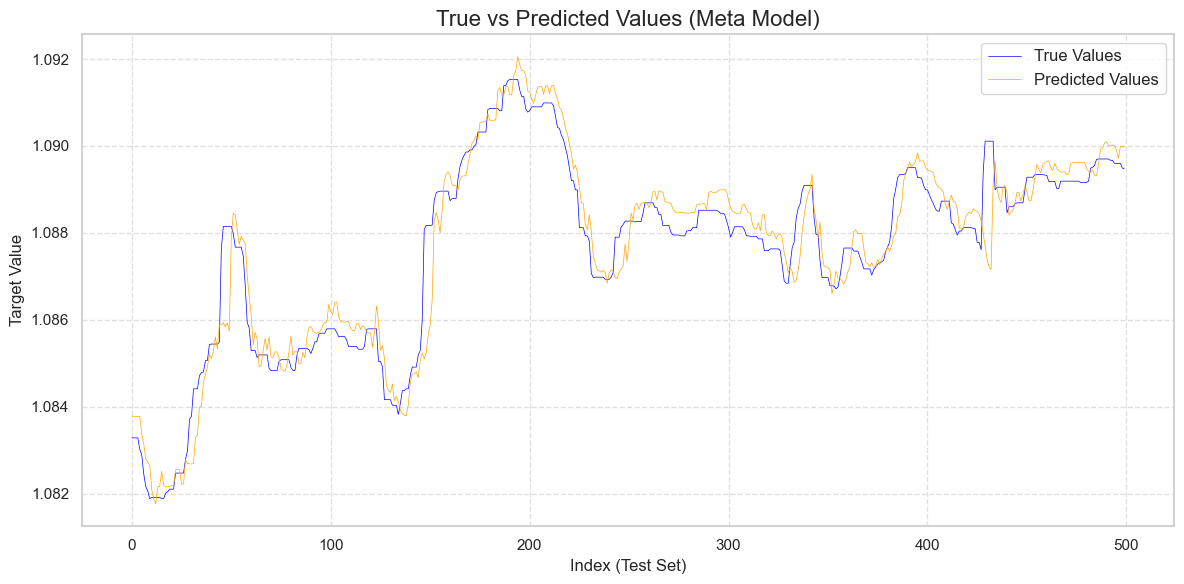

In [57]:
# plot y_test vs y_pred
# Plot the true and predicted values
start = 1000
end = 1500
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[start:end], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred_unscaled[start:end], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values (Meta Model)', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [60]:
os.chdir('..')

In [66]:
stacker = PredictModel()
stacker.stack_predict(X_test_20_final)

ValueError: in user code:

    File "c:\Users\ab6ri\OneDrive\Documents\Personal_Projects\simmer_bot\.venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ab6ri\OneDrive\Documents\Personal_Projects\simmer_bot\.venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ab6ri\OneDrive\Documents\Personal_Projects\simmer_bot\.venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ab6ri\OneDrive\Documents\Personal_Projects\simmer_bot\.venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\ab6ri\OneDrive\Documents\Personal_Projects\simmer_bot\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ab6ri\OneDrive\Documents\Personal_Projects\simmer_bot\.venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 1, 20), found shape=(None, 20)
